**Here we precist the cell state and locate the network prediction inside the t-SNE projection to look for insights for misclassified cells.**

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader

import sys
sys.path.append('../')

import config
from classfier_cell_state import CellStateClassifier
from classfier_cell_state import TranscriptomicsDataset

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from sklearn import manifold
import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE
import altair as alt
alt.data_transformers.disable_max_rows()

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


DataTransformerRegistry.enable('default')

In [2]:
@torch.no_grad()
def binary_acc(logits, targets):
    if logits.dim != targets.dim:
        targets = targets.unsqueeze(1)
    y_pred_tag = torch.sigmoid(logits)   
    y_pred_tag_round = torch.round(y_pred_tag)

    correct_results_sum = (y_pred_tag_round == targets).sum().float()
    acc = correct_results_sum / targets.shape[0]
    acc = torch.round(acc * 100)
    return acc, y_pred_tag

Init model and trainset

In [3]:
network = CellStateClassifier(num_genes=config.genes_per_single_cell)
network.load_state_dict(torch.load("../models/checkpoints/classifier_5kgenes.pth", map_location=torch.device('cpu')))
testset = TranscriptomicsDataset(filepath_data=f"../{config.filepath_test_toy}", device="cuda")
dataloader = DataLoader(testset, batch_size=1, shuffle=False)
network.eval()

data input has size: (3000, 5001)


CellStateClassifier(
  (fc1): Linear(in_features=5000, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=2500, bias=True)
  (fc3): Linear(in_features=2500, out_features=1, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=5000, out_features=10000, bias=True)
    (1): SELU()
    (2): Linear(in_features=10000, out_features=2500, bias=True)
    (3): SELU()
    (4): Linear(in_features=2500, out_features=1, bias=True)
  )
)

Inference and collect predicted labels

In [4]:
device = next(network.parameters()).device
accuracies = []
probs = []
labels = []
for batch_idx, (inputs, targets) in enumerate(dataloader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    logits = network(inputs)
    accuracy_mini_batch, prob = binary_acc(logits, targets)
    accuracies.append(accuracy_mini_batch)
    probs.append(prob)
    labels.append(targets)

probs = np.array([float(p) for p in probs])    

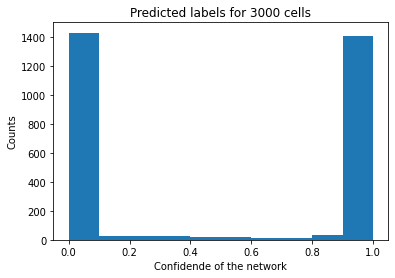

In [5]:
plt.hist(probs, density=False)
plt.title(f"Predicted labels for {len(probs)} cells")
plt.xlabel("Confidende of the network")
plt.ylabel("Counts")
plt.show()

In [6]:
labels_tolist = [int(l) for l in labels]

Confution Matrix

In [7]:
confusion_matrix(labels_tolist, [int(round(p)) for p in probs])

array([[1469,   38],
       [  52, 1441]])

In [8]:
tn, fp, fn, tp = confusion_matrix(labels_tolist, [int(round(p)) for p in probs]).ravel()
print(tn, fp, fn, tp)

1469 38 52 1441


Compute t-SNE on the data used for inference

In [9]:
test = "../data/Tran_RGC_scRNA/npys/toy-data/split-control_and_2w_after_crush_5000x5000_toy/test.npy"
load_test = np.load(test, allow_pickle=True)

In [17]:
load_test, load_test.shape

(array([[0, 0, 0, ..., 0, 0, 'control'],
        [0, 0, 0, ..., 0, 0, '2w_after_crush'],
        [0, 0, 0, ..., 0, 0, 'control'],
        ...,
        [0, 0, 0, ..., 0, 0, 'control'],
        [0, 0, 1, ..., 0, 0, 'control'],
        [0, 0, 0, ..., 0, 0, 'control']], dtype=object),
 (3000, 5001))

In [16]:
df_no_meta = load_test[:,:-1]
tsne_coords = manifold.TSNE(perplexity=50).fit_transform(df_no_meta)
df_tsne_coords_long_time_span = pd.DataFrame(tsne_coords, columns=['X','Y'])
df_tsne_coords_long_time_span.describe(), df_tsne_coords_long_time_span.shape

(                 X            Y
 count  3000.000000  3000.000000
 mean     -1.298232    -1.962711
 std      21.175743    17.697863
 min     -43.627628   -45.445129
 25%     -18.213693   -12.984466
 50%      -4.066461     1.128665
 75%      18.842143    12.987539
 max      38.940521    29.337688,
 (3000, 2))

In [18]:
probs_round = np.array([round(p) for p in probs])
correct = np.array(labels)==np.array(probs_round)
predictions_for_tsne = np.array(["correctly_classfied" if class_pred else "super_wrong" if not class_pred and prob>0.8 else "nope" for class_pred, prob in zip(correct, probs_tolist)])
print(sum(predictions_for_tsne=="correctly_classfied")), print("tot len",len(predictions_for_tsne))

/home/ionelia/pycharm-projects/master/semester2/internshipISTaustria/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  
/home/ionelia/pycharm-projects/master/semester2/internshipISTaustria/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


NameError: name 'probs_tolist' is not defined

In [13]:
sample_type_of_cells = pd.Series(load_test[:,-1])
predicted_labels = pd.Series(predictions_for_tsne)
tsne_with_meta_long_time_span = pd.concat([predicted_labels, sample_type_of_cells, df_tsne_coords_long_time_span], axis='columns')
tsne_with_meta_long_time_span = tsne_with_meta_long_time_span.rename(columns={0:"classification"})
tsne_with_meta_long_time_span = tsne_with_meta_long_time_span.rename(columns={1:"sample_type"})

NameError: name 'predictions_for_tsne' is not defined

In [ ]:
alt.Chart(tsne_with_meta_long_time_span).mark_point(
    opacity=0.6
).encode(
    x='X',
    y='Y',
    color='sample_type:N',
    size='classification',
    shape="classification",
).properties(
    width=700,
    height=700,
    title="Neuronal cells projected genes from after day 0, day 4, week 1, and week 2"
).interactive()

In the the projection below we can see that the misclassfied ones with a proabability > 0.8 are mostly found in the overlap area. It would be interesting to see which  genes and transcription factors regulaate that are and which are only found there/or not found at all.
<img src="../assets/tsne_control_2w_infered_states.png"> 

t-SNE on the full data {control and 2 weeks}. Here we want to check weather this overlap exist in the full dataset.

In [28]:
full_control_2w = "../data/Tran_RGC_scRNA/npys/stacked/control_2w.npy"
load_full_control_2w = np.load(full_control_2w, allow_pickle=True)
df_no_meta_full_control_2w = load_full_control_2w[1:,:-1]

In [72]:
tsne_coords_full_control_2w = manifold.TSNE(perplexity=15).fit_transform(df_no_meta_full_control_2w)

In [73]:
df_tsne_coords_full_control_2w = pd.DataFrame(tsne_coords_full_control_2w, columns=['X','Y'])
sample_type_of_cells_full_control_2w = pd.Series(load_full_control_2w[1:,-1])

tsne_with_meta_full_control_2w= pd.concat([sample_type_of_cells_full_control_2w, df_tsne_coords_full_control_2w], axis='columns')
tsne_with_meta_full_control_2w = tsne_with_meta_full_control_2w.rename(columns={0:"sample_type"})

alt.Chart(tsne_with_meta_full_control_2w).mark_point(
    opacity=0.6
).encode(
    x='X',
    y='Y',
    color='sample_type:N',
    shape='sample_type:N'
).properties(
    width=700,
    height=700,
    title="Neuronal cells projected genes from after day 0, and week 2"
).interactive()

alt.Chart(...)

$\text{where} P_i \text{is the production rate of pre-mRNA (unspliced transcript) that} \\ \text{includes regulatory interactions, are the degradation and splicing rate} \\ \text{respectively} \text{of pre-mRNA and} q^u_i \text{is the noise of the transcription of} \\ \text{pre-mRNA. Also,} \gamma_i \text{is the degradation rate of spliced mRNA and}\\ q^s_i \text{is the noise of the transcription of spliced mRNA.} \\ \alpha, \beta, \phi \text{and} \gamma \text{are independent Gaussian white noise processes.}$